In [3]:
# ============================================================
# Notebook setup
# ============================================================

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from util import nab
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# Load data
data_folder = 'data/nab'

file_name1 = 'realTweets/Twitter_volume_AMZN.csv'
data1, labels1, windows1 = nab.load_series(file_name1, data_folder)

file_name2 = 'realTraffic/occupancy_6005.csv'
data2, labels2, windows2 = nab.load_series(file_name2, data_folder)

# Basic Approaches for Missing Values

## Basic Approaches for Missing Values

**We will now discuss a few simple approaches to deal with missing values**

* We cannot easily assess them on our traffic data
* ...Since we do not know the ground truth of each missing value

**Therefore, we will initially use _partially synthetic data_**

* We will start from a time series without any missing value, then remove values artificially
* ...And measure the accuracy of our filling approaches via the Root MSE

$$
\mathit{RMSE} = \sqrt{\frac{1}{n}\sum_{i = 0}^n (\tilde{x}_i - \hat{x}_i)^2}
$$

Where $\tilde{x}_i$ is a value from the filled series and $\hat{x}_i$ the ground truth

* $\tilde{x}_i = \hat{x}_i$ if no value is missing
* Hence, any MSE difference is entirely due to missing values

## The Benchmark Dataset

**Our benchmark dataset consists of twitter volume related to amazon.com**

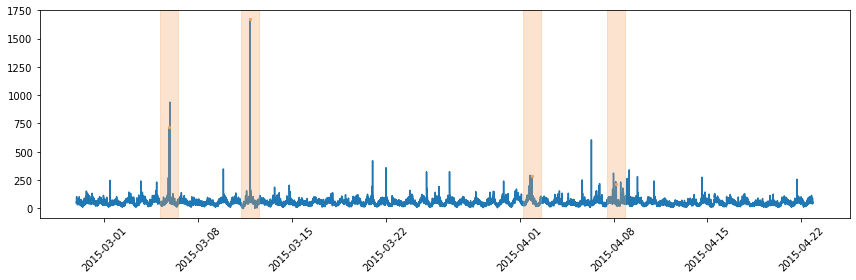

In [4]:
nab.plot_series(data1, labels1, windows1)

* There are a few anomalies, but we are not concerned with them
* Then series has a seasonal/periodic component

## The Benchmark Dataset

**We now introduce some missing values**

First, we draw some starting points at random

In [5]:
np.random.seed(42) # seed (to get reproducible results)
mv_num = 30 # number of intervals with missing values
mv_starts = np.random.choice(range(len(data1.index)), mv_num, replace=False)
mv_starts.sort()
mv_starts[:4]

array([ 88, 123, 169, 304])

Then, we clear values over increasingly long intervals:

In [6]:
data1_mv = data1.copy()
for i in range(mv_num):
    data1_mv.iloc[mv_starts[i]:mv_starts[i]+i+1] = np.NaN

* The first interval contains 1 missing value, the second 2, the third 3...

## The Benchmark Dataset

**Let's have a look at the results around one of the "holes"**

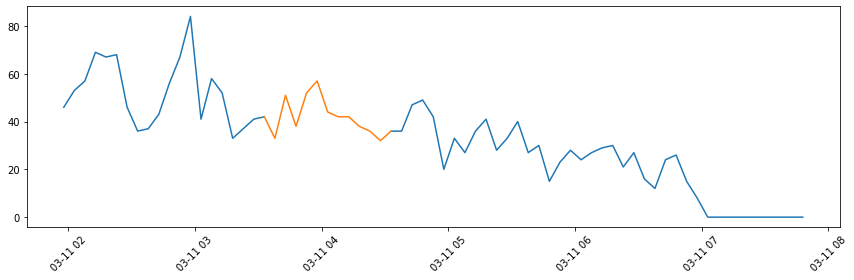

In [7]:
idx, pad = 10, 20
nab.plot_series(data1_mv.iloc[mv_starts[idx]-pad:mv_starts[idx]+mv_num+pad+1])
plt.plot(data1.iloc[mv_starts[idx]-1:mv_starts[idx]+idx+2]);

* The orange part corresponds to the removed values

## Forward/Backward Filling

**The easiest approach for missing values consists in _replicating nearby observations_**

* _Forward filling:_ propagate forward the last valid observation
* _Backward filling:_ propagate backward the next valid observation

**An important observation:**

* When filling missing values, _we have access to the whole series_
* ...So we can reason _both forward and backwards_

**Forward/backward filling are simple methods, but they can work well**

* Rationale: most time series have a certain "inertia"
* ...I.e.: a strong level of local correlation
* For this reason, the last observation is a good predictor for the next one
* ...Remember the _persistence_ predictor?

## Forward/Backward Filling

**Forward and backward filling are pre-implemented in pandas**

They are available through the `fillna` method:

```python
DataFrame.fillna(..., method=None, ...)
```

* `fillna` replaces `NaN` values in a `DataFrame` or `Series`
* The `method` parameter can take the values:
  * "pad" or "ffill": these correspond to forward filling
  * "backfill" or "bfill": these correspond to backward filling

They are generally applied to datasets with a dense index

* Remember that our benchmark dataset already has a dense index

## Forward/Backward Filling on the Benchmark

**We can finally test forward/backward filling**

In [8]:
ffseries = data1_mv.fillna(method='ffill')
bfseries = data1_mv.fillna(method='bfill')

We can check the corresponding MSE:

In [9]:
from sklearn.metrics import mean_squared_error
rmse_ff = np.sqrt(mean_squared_error(data1, ffseries))
rmse_bf = np.sqrt(mean_squared_error(data1, bfseries))
print(f'RMSE for forwad filling: {rmse_ff:.2f}, for backward filling {rmse_bf:.2f}')

RMSE for forwad filling: 3.18, for backward filling 6.45


* In this case forward filling seems to work better
* The results are of course application-dependent

## Forward/Backward Filling on the Benchmark

**Let's have a close look at forward filling around some of the missing values**

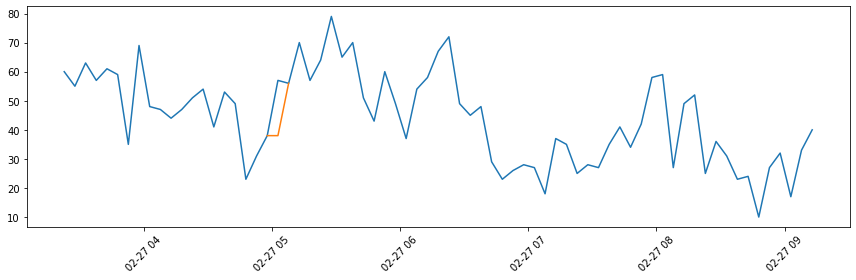

In [10]:
idx, pad = 0, 20
nab.plot_series(data1.iloc[mv_starts[idx]-pad:mv_starts[idx]+mv_num+pad+1])
plt.plot(ffseries.iloc[mv_starts[idx]-1:mv_starts[idx]+idx+2]);

* This is the first (and shortest) gap

## Forward/Backward Filling on the Benchmark

**Let's have a close look at forward filling around some of the missing values**

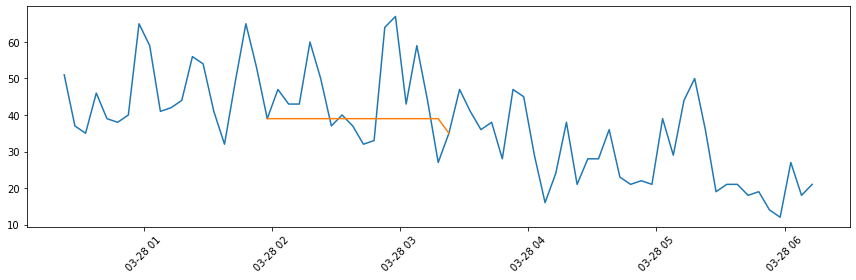

In [11]:
idx, pad = mv_num//2, 20
nab.plot_series(data1.iloc[mv_starts[idx]-pad:mv_starts[idx]+mv_num+pad+1])
plt.plot(ffseries.iloc[mv_starts[idx]-1:mv_starts[idx]+idx+2]);

* This is an intermediate-length gap

## Forward/Backward Filling on the Benchmark

**Let's have a close look at forward filling around some of the missing values**

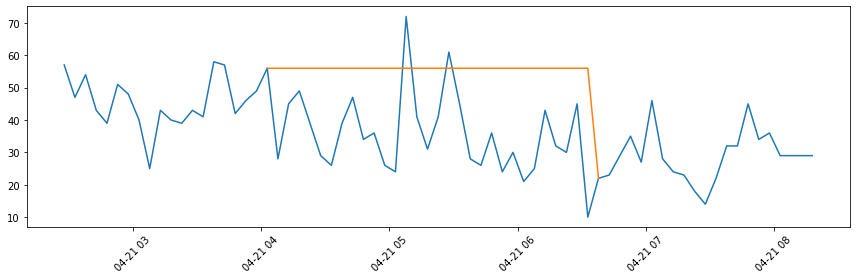

In [12]:
idx, pad = mv_num-1, 20
nab.plot_series(data1.iloc[mv_starts[idx]-pad:mv_starts[idx]+mv_num+pad+1])
plt.plot(ffseries.iloc[mv_starts[idx]-1:mv_starts[idx]+idx+2]);

* This is the longest gap

## Forward/Backward Filling on the Traffic Data

**Let's now consider the traffic data**

We will limit ourselves to forward filling:

In [13]:
ddata2 = nab.densify(data2, freq='5min')
ddata2_ff = ddata2.fillna(method='ffill')

* `data2` contains the traffic series

**We now isolate the filled values**

This is needed so that we can highlight them in the forthcoming plots

In [14]:
ddata2_ffonly = ddata2_ff.copy()
ddata2_ffonly[~ddata2['value'].isnull()] = np.nan

* `ffseries` and `bfseries` now contain _only_ the filled values

## Forward/Backward Filling on the Traffic Data

**Let us have a look at the results of forward filling:**

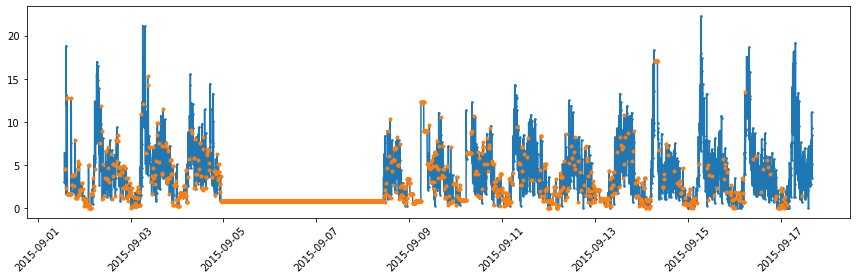

In [15]:
nab.plot_series(ddata2_ff, show_markers=True)
plt.scatter(ddata2_ffonly.index, ddata2_ffonly, marker='.', c='tab:orange');

## Forward/Backward Filling on the Traffic Data

**Forward filling works reasonably for small gaps**

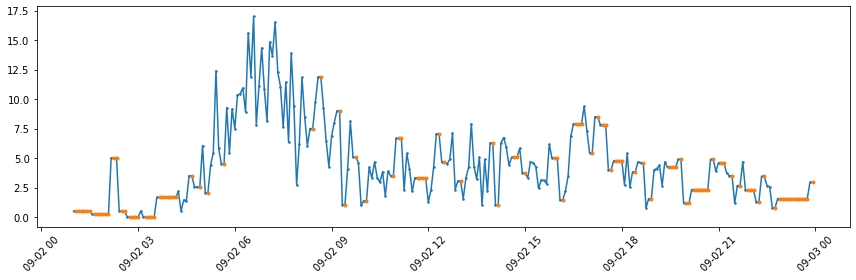

In [16]:
mask = (ddata2_ff.index >= '2015-09-02 01:00') & (ddata2_ff.index < '2015-09-03 00:00')
nab.plot_series(ddata2_ff[mask], show_markers=True)
plt.scatter(ddata2_ffonly.index[mask], ddata2_ffonly[mask], marker='.', c='tab:orange');

## Forward/Backward Filling with our Series

**...But it is not particularly effective for larger gaps**

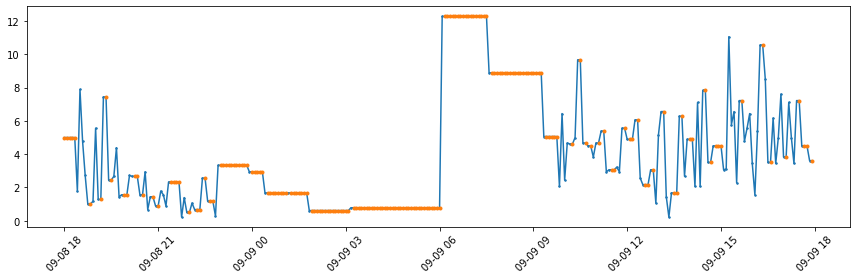

In [17]:
mask = (ddata2_ff.index >= '2015-09-08 18:00') & (ddata2_ff.index < '2015-09-09 18:00')
nab.plot_series(ddata2_ff[mask], show_markers=True)
plt.scatter(ddata2_ffonly.index[mask], ddata2_ffonly[mask], marker='.', c='tab:orange');

## (Geometric) Interpolation

**A few more options are available via [the `interpolate` method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)**

```python
DataFrame/Series.interpolate(method='linear', ...)
```

The `method` parameter determines how NaNs are filled:

* "linear" uses a linear interpolation, assuming uniformly spaced samples
* "time" uses a linear interpolation, but supports non-uniformly spaced samples
* "nearest" uses the closest value
* "polynomial" uses a polynomial interpolation
* Even "ffill" and "bfill" are available

Both "polynomial" and "spline" require to specify the additional parameter `order`

* E.g. `df.interpolate(method='polynomial', order='3')`

## (Geometric) Interpolation

**Let us check the performance of some approaches**

In [18]:
args = [{'method':'linear'}, {'method':'time'}, {'method':'nearest'},
        {'method':'polynomial', 'order': 2}]

for a in args:
    tmp = data1_mv.interpolate(**a)
    rmse = np.sqrt(mean_squared_error(data1, tmp))
    print(f'RMSE for {a["method"]}: {rmse:.2f}')

RMSE for linear: 4.42
RMSE for time: 4.42
RMSE for nearest: 4.95
RMSE for polynomial: 17.89


* "linear" and "time" are equivalent in this case (we have uniformly-spaced samples)
* "polynomial" is the most complex, and in this case also the worst

All perform _worse_ than forward filling (at least in this case)!

## Curve Interpolation on Traffic Data

**On real data, we cannot (easily) compare interpolation methods**

* This is because typically we have _no ground truth_
* For now, we will settle for a visual inspection

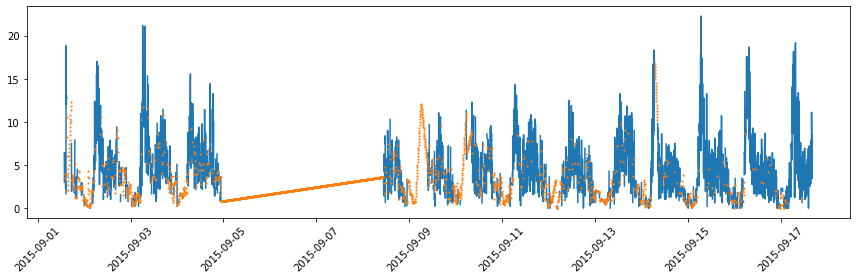

In [19]:
ddata2_ln = ddata2.interpolate(method='linear')
nab.plot_series(ddata2, filled_version=ddata2_ln)

## Considerations

**All these methods for dealing with missing values:**

* Work ok for small gaps, but loose effectiveness as the gap size grows
* This is true _even for the more advanced_ filling methods!
* Better methods just degrade a bit more slowly

**MSE comparisons can be very effective:**

* But requires access to ground truth!
* An idea: _make_ your ground truth by artificially removing values
* ...Then comparing filling methods based on their performance on the artificial gaps

**MSE is not everything**

* Every filling method makes mistakes: it's important not to make the _wrong ones_
* Think about how you plan to use your (filled) time series
* Can you expect the series to have uniform variance?